In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import time
import os
import time
import pdb
import glob

# proxyの設定．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.autograd import Variable
from sklearn.svm import LinearSVC


### DreapDream
from 本部先輩のソースコード

In [2]:
def deepdream(img_path,enhance_layer):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # define model  enhance_layer番目の層までを抽出                                                                           
    model = models.vgg16(pretrained=True).features
    layers = list(model.children())
    model = nn.Sequential(*layers[:enhance_layer]).to(device).eval()
    for p in model.parameters():
        p.requires_grad_(False)
        
    #data->torchtensor
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512,512), interpolation=cv2.INTER_AREA)

    # transforms(724, 1024, 3)->torch.Size([1, 3, 512, 512])                                                                            
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    totensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=mean, std=std)
    transform = transforms.Compose([totensor, normalize])

    x_org = transform(img).unsqueeze(0)

    
    noct = 20
    niter = 200
    oct_scale =1.2
    lr = 0.001
    for ioct in range(noct):
            #print(ioct)

            #画像をリサイズ小さい画像から
            s = x_org.shape[2]//int(oct_scale**(noct-ioct-1))
            x_base = F.adaptive_avg_pool2d(x_org, s).to(device)

            if ioct == 0:
                x = x_base
            else:
                #画像のサイズが大きくなった時のエッジ保持
                x = x_base + F.interpolate(x, s, mode='bicubic', align_corners=False)

            x = x.detach().requires_grad_(True)
            for i in range(niter):
                y = model.forward(x)
                #lossは出力の二乗和
                loss = y.norm()
                #逆伝播
                loss.backward()
                #画像の勾配更新
                avg_grad = torch.abs(x.grad).mean().item()
                norm_lr = lr/avg_grad
                x.data += norm_lr * x.grad.detach() # 勾配と逆方向に移動                           
                for j in range(3):
                    upper = (1-mean[j])/std[j]
                    lower = -mean[j]/std[j]
                    #更新値修正
                    x.data[:,j] = torch.clamp(x.detach()[:,j], lower, upper)
                x.grad.detach().zero_()
                
            #画像のエッジ保持
            x.data -= x_base
            
    # 出力用の整形                                                                             
    x = (x+x_base).to('cpu')
    mean = mean.reshape(1,3,1,1).to('cpu')
    std = std.reshape(1,3,1,1).to('cpu')
    x = torch.clamp((x*std + mean)*255, 0, 255)#0~255に戻す
    x = x.detach().type(torch.uint8)
    x = x.squeeze().permute(1,2,0)
    return x

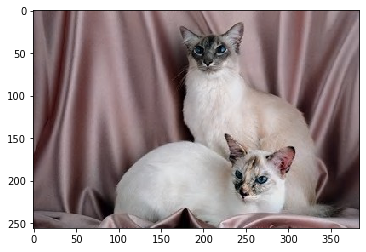

In [9]:
plt.imshow(Image.open('animal/cat/458008.jpg'))

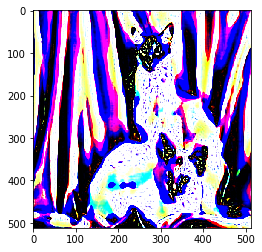

In [4]:
plt.imshow(deepdream('animal/cat/458008.jpg',2))

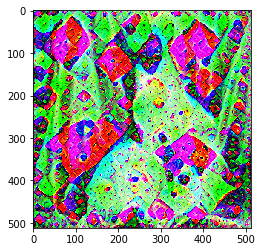

In [5]:
plt.imshow(deepdream('animal/cat/458008.jpg',10))

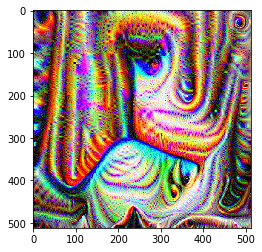

In [6]:
plt.imshow(deepdream('animal/cat/458008.jpg',15))

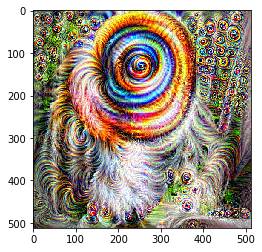

In [7]:
plt.imshow(deepdream('animal/cat/458008.jpg',20))

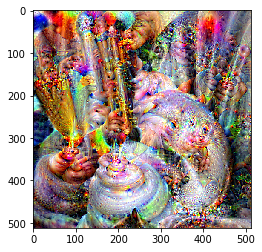

In [3]:
plt.imshow(deepdream('animal/cat/458008.jpg',28))

スライドの方でなんとなくの方法は分かったが、具体的な方針が立たなかったので、本部先輩のコードをお借りした。<br>
任意の層まで取り出して、誤差を更新する際の傾きを通常と反対方向にすることで、わずかな特徴を強調させ、それを繰り返し行うことで、画像の特徴が強調される。<br>
そして、特徴を出すために手法として写真を分割して、段々サイズを大きくしている。<br>
層が浅いところで強調すると、直線的で抽象的な絵が、ある程度深いところだと形が形成され、深いところになると、元の画像の特徴を強調されたような画像が生成される。よくスライドである最初の層では大雑把な特徴を取り出し、深い層では高次元の特徴が取り出されていることが示されているとわかる<br>
案外20層の画像が怖く出来、deep dreamだなと思った。絵画にするならここら辺だなと思う。<br>

参考<br>
https://www.slideshare.net/HarumitsuNobuta/deep-dream<br>